# Lab 10: Regression on Big(ger) Data

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. The Dataset

In this lab, we are exploring movie screenplays. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table.

In [2]:
movies = Table.read_table('movies.csv')
movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
wild wild west,1999,4.3,comedy,3446,0,0,0.0212635,0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [3]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('the terminator')

Row(Title='the terminator', Year='1984', Rating=8.1, Genre='thriller', # Words=2210, she=0.0024084778420038, decid=0.0009633911368015, talk=0.001926782273603, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.0, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.0, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.0004816955684007, cigarett=0.0004816955684007, jesu=0.0, mani=0.0, violin=0.0, financi=0.0, bai=0.0, cop=0.0004816955684007, neighbor=0.0, cd=0.0, england=0.0, made=0.0004816955684007, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0004816955684007, waltz=0.0, behind=0.0, bourbon=0.0, favorit=0.0, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=0.0, sophi=0.0, third=0.0, exist=0.0009633911368015, wouldv=0.0, hero=0.0

For example, the fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. Check the original table to see if this worked for you!

In [4]:
row_for_title('the terminator').item('none')

0.0009633911368015

#### Question 1.1
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns.

<!--
BEGIN QUESTION
name: q1_1
-->

In [5]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [6]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 370


## 2. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [7]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 2.1
Assign `stemmed_message` to the stemmed version of the word "vegetables".

<!--
BEGIN QUESTION
name: q2_1
-->

In [8]:
stemmed_message = 'veget'
stemmed_message

'veget'

#### Question 2.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem.

<!--
BEGIN QUESTION
name: q2_2
-->

In [9]:
most_stem = vocab_table.group('Stem').sort('count', descending = True).column('Stem').item(0)
most_stem

'gener'

#### Question 2.3
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "albatross" or "batman", you should pick "batman").

<!--
BEGIN QUESTION
name: q2_3
-->

In [10]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

tbl_with_lens = vocab_table.with_columns(
    'Stem Length', vocab_table.apply(len, 'Stem'),
    'Word Length', vocab_table.apply(len, 'Word')
)
tbl_with_dif = tbl_with_lens.with_column('Difference', tbl_with_lens.column('Word Length') - tbl_with_lens.column('Stem Length'))


longest_uncut = tbl_with_dif.where('Difference', 0).sort('Word Length', descending = True).column('Stem').item(1)
longest_uncut

'misunderstand'

## 3. Exploratory Data Analysis: Linear Regression

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table.

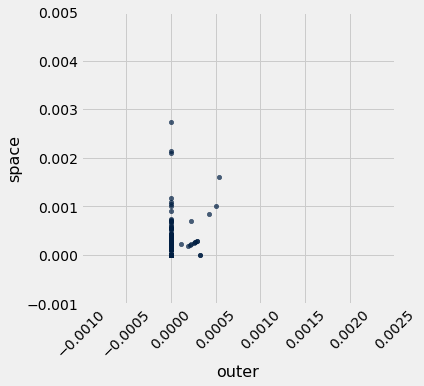

In [11]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.001, 0.0025, -0.001, 0.005]);
plots.xticks(rotation=45);

#### Question 3.1
Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

<!--
BEGIN QUESTION
name: q3_1
-->

In [12]:
# Our solution took multiple lines
# these two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.mean(outer)) / np.std(outer)
space_su = (space - np.mean(space)) / np.std(space)

outer_space_r = np.mean(outer_su * space_su)
outer_space_r

0.2829527833012746

#### Question 3.2
Choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 that are not *outer* and *space* and plot a scatter plot with a line of best fit for them. The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`.

*Hint: It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*.

*Hint 2: Try to think of common phrases or idioms*.

<!--
BEGIN QUESTION
name: q3_2
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

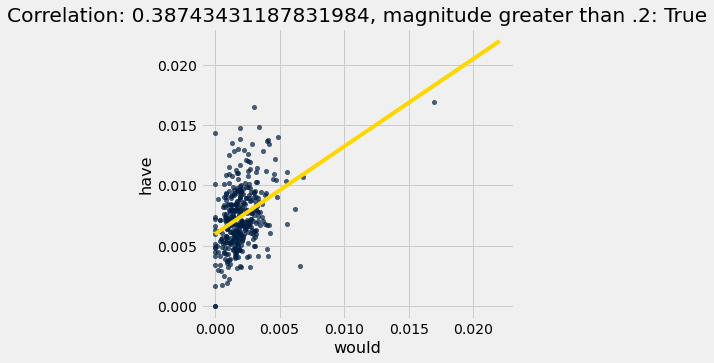

In [13]:
word_x = 'would'
word_y = 'have'

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.mean(arr_x)) / np.std(arr_x)
y_su = (arr_y - np.mean(arr_y)) / np.std(arr_y)

r = np.mean(x_su * y_su)

slope = r * np.std(arr_y) / np.std(arr_x)
intercept = np.mean(arr_y) - slope * np.mean(arr_x)

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

#### Question 3.3
The slope is a ratio, meaning that for two movies that are 1 unit apart in terms of the proportion of your word_x, our prediction of the proportion of words in the script that are word_y will differ by this slope. Since our data are proportions between 0 and 1, a one unit increase doesn't make a lot of sense in this context. 

How might you use this slope (or a manipulation of it) to better describe how the proportion of word_y is predicted to change based on the proportion of word_x in a script?

<!--
BEGIN QUESTION
name: q3_3
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

*When the proportion of word_x is multiplied by the ratio of word_y to word_x (the slope), it results in the proportion of word_y.*

## 4. Exploratory Data Analysis: Multiple Linear Regression

In class we saw that the best fit regression line used to predict y with x minimized the root mean squared errors (rmse). 

$$
rmse ~=~ \sqrt{mean{(y - y_{estimate})}^2}
$$



#### Question 4.1
Define the function below to calculate the root mean squared errors for a regression line that uses the word_x as predictor for the word_y.

In [14]:
def x_y_words_rmse(any_slope, any_intercept):
    x = movies.column(word_x)
    y = movies.column(word_y)
    estimate = (x * any_slope) + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

Run the cell below to see that the minimize function will (most likely) output the same values for the slope and intercept that you calculated in question 3.2

In [15]:
minimize(x_y_words_rmse)

array([0.72705492, 0.00596336])

This method of using the minimize function to find the minimum root mean squared value for a function can be extended to nonlinear model as well as to multiple predictors. Choose two new words word_w and word_z that you think may be reasonably correlated with your word_y. You will then use these words to construct a multiple regression model to predict the proportion of the words in the script that are your word_y, based on the proportions of your w, x, and z words.


$$
y_{estimate} ~=~ a*word_w + b*word_x + c*word_z + d
$$

for constants $a$, $b$, $c$, and $d$.

#### Question 4.2 

Define the function below to calculate the root mean squared errors for a regression line that uses the w, x, and z words as predictors for the word_y.

In [16]:
def w_x_z_y_words_rmse(a, b, c, d):
    x = movies.column(word_x)
    y = movies.column(word_y)
    w = movies.column('been')
    z = movies.column('be')
    
    estimate = (a *  w) + (b * x) + (c * z) + d 
    return (np.mean((y - estimate) ** 2)) ** 0.5

#### Question 4.3

Us the minimize function to find the coefficients a, b, c, and d that result in the minimal root mean squared error.

In [17]:
minimize(w_x_z_y_words_rmse)

array([0.25333647, 0.70284697, 0.18306928, 0.00418844])

#### Question 4.4

For the movie The Terminator, what proportion of the words in the script does you model predict will be your word_y (using the proportion of your word_w, word_x, and word_z)

In [20]:
terminator_w = row_for_title('the terminator').item('been')
terminator_x = row_for_title('the terminator').item('would')
terminator_z = row_for_title('the terminator').item('be')

estimate = (0.25333647 *  terminator_w) + (0.70284697 * terminator_x) + (0.18306928 * terminator_z) + 0.00418844 
estimate

0.00674494831406546

You have finished lab 10! We'll use this data again in lab 11 in an attempt to classify the genre of movies.